# Phase II - Neural Networks in Focus Species

## Import Modules

In [ ]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.utils.data as Data
from sklearn.preprocessing import StandardScaler
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# set seed
torch.cuda.manual_seed(1)
# Switch to GPU for Training
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
# Clear GPU caches
torch.cuda.empty_cache()
# print(torch.cuda.memory_summary())

## Hyper-parameters Setup

In [3]:
batch_size = 50
take_log = False

## Load datset & Feature Engineering

In [4]:
# set random seed
np.random.seed(seed=2)
# load dataset
trainset = pd.read_csv("phase_2_trainset.csv")
testset = pd.read_csv("phase_2_testset.csv")

In [5]:
# get species list
species_list = list(set([i for i in trainset["species_cat_02"]]))
label_dict = {}
for i, spe in enumerate(species_list):
    label_dict[spe] = i
label_dict

{'Mytilus californianus': 0,
 'Anthopleura elegantissima': 1,
 'Balanus glandula': 2,
 'Egregia menziesii': 3,
 'Pollicipes polymerus': 4}

In [6]:
# generate label column
trainset["label"] = trainset["species_cat_02"].apply(lambda x: label_dict[x])
testset["label"] = testset["species_cat_02"].apply(lambda x: label_dict[x])
trainset = trainset.sample(frac=1)
testset = testset.sample(frac=1)

In [7]:
trainset = np.array(trainset)
testset = np.array(testset)
print("Trainset Shape: ", trainset.shape)
print("Testset Shape: ", testset.shape)

Trainset Shape:  (13356, 3)
Testset Shape:  (290, 3)


### Train/Test Split and Data Preparation

In [8]:
train_x = trainset[:,0].reshape(-1,1)
train_y = trainset[:,-1]
test_x = testset[:,0].reshape(-1,1)
test_y = testset[:,-1]

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(13356, 1) (13356,)
(290, 1) (290,)


## Training Piepeline

### Normalization

In [9]:
scaler_minmax = StandardScaler()
train_x = scaler_minmax.fit_transform(train_x)
test_x = scaler_minmax.fit_transform(test_x)

### Conver to Tensors

In [10]:
# float32 conversion
train_x = train_x.astype(np.float32)
train_y = train_y.astype(np.int32)
test_x = test_x.astype(np.float32)
test_y = test_y.astype(np.int32)

### Dataloaders

In [11]:
class Species_Datasets(torch.utils.data.Dataset):
    def __init__(self, data_inputs, data_targets):
        self.inputs = torch.FloatTensor(data_inputs)
        self.label = torch.FloatTensor(data_targets)

    def __getitem__(self, idx):
        x = self.inputs[idx]
        y = self.label[idx]
        return x, y

    def __len__(self):
        return len(self.label)

In [12]:
trainset = Species_Datasets(train_x, train_y)
testset = Species_Datasets(test_x, test_y)
TrainDataLoader = Data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=False)
TestDataLoader = Data.DataLoader(testset, batch_size=batch_size, shuffle=True, drop_last=False)

In [13]:
for batch_idx, (data, targets) in enumerate(TrainDataLoader):
    print(data.shape,targets.shape)
    print(data[0].shape)
    break

torch.Size([50, 1]) torch.Size([50])
torch.Size([1])


### Deep Neural Networks

In [14]:
class DNN_Model(nn.Module):
    # Networks
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(train_x.shape[1],16)
        self.hidden2 = nn.Linear(16,32)
        self.hidden3 = nn.Linear(32,16)
        self.out = nn.Linear(16,len(label_dict))
        self.activation = nn.Sigmoid()
        self.dropout = nn.Dropout(0.1)

    # Feed Forward
    def forward(self, x):
        x = self.hidden1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.hidden2(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.hidden3(x)
        x = self.activation(x)
        x = self.out(x)
        return x

In [15]:
net = DNN_Model().to(device) # Create a net instance
net

DNN_Model(
  (hidden1): Linear(in_features=1, out_features=16, bias=True)
  (hidden2): Linear(in_features=16, out_features=32, bias=True)
  (hidden3): Linear(in_features=32, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=5, bias=True)
  (activation): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
)

### Training Model

In [16]:
# Preparing list to record
summary_train_loss = []
summary_train_accuracy = []
summary_val_loss = []
summary_val_accuracy = []

In [17]:
# Function: Train model
def model_fit_train(class_weight, learning_rate, epochs, summary_train_loss, summary_train_accuracy, summary_val_loss, summary_val_accuracy):
    if class_weight != None:
        loss_func = torch.nn.CrossEntropyLoss(weight = class_weight)
    else:
        loss_func = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr = learning_rate)

    for epoch in tqdm(range(epochs), desc='Training'):
        train_accuracy = []
        train_loss = []
        val_accuracy = []
        val_loss = []
        
        # ===== Train Mode =====
        net.train()
        for batch_idx, (x_input, y_true) in enumerate(TrainDataLoader):
            # Put data to device
            x_input = x_input.to(device)
            y_true = y_true.to(device)
            # Fit model
            y_pred = net(x_input)
            # Compute loss
            loss = loss_func(y_pred,y_true.long())
            # Reset gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Get prediction
            prediction = torch.max(y_pred,1)[1]
            prediction = prediction.data.cpu().numpy().squeeze()

            label = y_true.data.cpu().numpy()
            # Compute accuracy
            accuracy = float((prediction == label).astype(int).sum())/float(prediction.size)
            # Append loss and accuracy
            train_loss.append(loss.item())
            train_accuracy.append(accuracy)
        # append the average result from one epoch
        summary_train_loss.append(np.mean(np.array(train_loss)))
        summary_train_accuracy.append(np.mean(np.array(train_accuracy)))
        

        # ===== Validation Mode =====
        net.eval()
        val_prediction_list = [] # record the validation prediction result for confusion matrix computation
        val_true_list = []
        for batch_id, (val_data,val_label) in enumerate(TestDataLoader):
            # Put data to device
            x_val = val_data.to(device)
            y_val = val_label.to(device)
            # get prediction
            val_pred = net(x_val)
            # Compute loss
            val_losses = loss_func(val_pred,y_val.long())
            # prediction
            val_pred = torch.max(val_pred,1)[1]
            val_pred = val_pred.data.cpu().numpy().squeeze()
            # append val_prediction_list
            val_prediction_list += val_pred.tolist()
            
            val_label = y_val.data.cpu().numpy()
            val_true_list += val_label.tolist() 
            
            # Compute accuracy
            val_acc = float((val_pred == val_label).astype(int).sum())/float(val_pred.size)
            # Append loss and accuracy
            val_loss.append(val_losses.item())
            val_accuracy.append(val_acc)
        # append the average result from one epoch
        summary_val_loss.append(np.mean(np.array(val_loss)))
        summary_val_accuracy.append(np.mean(np.array(val_accuracy)))
        
        # print result
        if str(epoch).endswith("0"):
            print("Epoch: ",epoch+1,"/",epochs,"Training Loss: ", summary_train_loss[-1], "| Training Accuracy: ", summary_train_accuracy[-1], "| Validation Loss: ", summary_val_loss[-1], "| Validation Accuracy: ", summary_val_accuracy[-1])
    return val_true_list, val_prediction_list

#### Phase II - Training

In [18]:
epochs = 150
learning_rate = 0.00005
class_weights = torch.tensor([1.0,1.0,1.0,1.0,1.0])

In [19]:
val_true_list, val_pred_list = model_fit_train(class_weights, learning_rate, epochs, summary_train_loss, summary_train_accuracy, summary_val_loss, summary_val_accuracy)

Training:   1%|          | 1/150 [00:00<00:52,  2.82it/s]

Epoch:  1 / 150 Training Loss:  1.6227478798645645 | Training Accuracy:  0.21398009950248761 | Validation Loss:  1.6228158076604207 | Validation Accuracy:  0.1975


Training:   7%|▋         | 11/150 [00:04<00:51,  2.71it/s]

Epoch:  11 / 150 Training Loss:  1.599918374819542 | Training Accuracy:  0.2537313432835821 | Validation Loss:  1.6063209374745686 | Validation Accuracy:  0.21583333333333332


Training:  14%|█▍        | 21/150 [00:07<00:46,  2.80it/s]

Epoch:  21 / 150 Training Loss:  1.5662153692387824 | Training Accuracy:  0.3906716417910448 | Validation Loss:  1.5694493254025776 | Validation Accuracy:  0.38916666666666666


Training:  21%|██        | 31/150 [00:11<00:43,  2.76it/s]

Epoch:  31 / 150 Training Loss:  1.4438755160837031 | Training Accuracy:  0.4024378109452736 | Validation Loss:  1.4392775495847066 | Validation Accuracy:  0.375


Training:  27%|██▋       | 41/150 [00:14<00:39,  2.76it/s]

Epoch:  41 / 150 Training Loss:  1.356397815604708 | Training Accuracy:  0.40676616915422886 | Validation Loss:  1.34501447280248 | Validation Accuracy:  0.39166666666666666


Training:  34%|███▍      | 51/150 [00:18<00:35,  2.81it/s]

Epoch:  51 / 150 Training Loss:  1.3265360825097383 | Training Accuracy:  0.4089054726368159 | Validation Loss:  1.3165014584859211 | Validation Accuracy:  0.4083333333333334


Training:  41%|████      | 61/150 [00:22<00:32,  2.75it/s]

Epoch:  61 / 150 Training Loss:  1.3197833535386556 | Training Accuracy:  0.4091044776119403 | Validation Loss:  1.3028297622998555 | Validation Accuracy:  0.4166666666666667


Training:  47%|████▋     | 71/150 [00:25<00:28,  2.79it/s]

Epoch:  71 / 150 Training Loss:  1.3167278117208339 | Training Accuracy:  0.40888059701492535 | Validation Loss:  1.2958308855692546 | Validation Accuracy:  0.43333333333333335


Training:  54%|█████▍    | 81/150 [00:29<00:25,  2.76it/s]

Epoch:  81 / 150 Training Loss:  1.309382575216578 | Training Accuracy:  0.41156716417910444 | Validation Loss:  1.29475071032842 | Validation Accuracy:  0.42166666666666663


Training:  61%|██████    | 91/150 [00:32<00:21,  2.78it/s]

Epoch:  91 / 150 Training Loss:  1.307972841743213 | Training Accuracy:  0.4135820895522388 | Validation Loss:  1.2843034267425537 | Validation Accuracy:  0.42166666666666663


Training:  67%|██████▋   | 101/150 [00:36<00:17,  2.80it/s]

Epoch:  101 / 150 Training Loss:  1.3075253803338578 | Training Accuracy:  0.41253731343283584 | Validation Loss:  1.288597822189331 | Validation Accuracy:  0.42416666666666664


Training:  74%|███████▍  | 111/150 [00:40<00:13,  2.81it/s]

Epoch:  111 / 150 Training Loss:  1.3042558654030758 | Training Accuracy:  0.4124378109452736 | Validation Loss:  1.2798128724098206 | Validation Accuracy:  0.44


Training:  81%|████████  | 121/150 [00:43<00:10,  2.78it/s]

Epoch:  121 / 150 Training Loss:  1.3033792616716071 | Training Accuracy:  0.4119154228855721 | Validation Loss:  1.279621660709381 | Validation Accuracy:  0.425


Training:  87%|████████▋ | 131/150 [00:47<00:06,  2.79it/s]

Epoch:  131 / 150 Training Loss:  1.3017049485178136 | Training Accuracy:  0.4155223880597015 | Validation Loss:  1.2802729209264119 | Validation Accuracy:  0.42250000000000004


Training:  94%|█████████▍| 141/150 [00:51<00:03,  2.75it/s]

Epoch:  141 / 150 Training Loss:  1.299867633563369 | Training Accuracy:  0.4159950248756219 | Validation Loss:  1.2751079003016155 | Validation Accuracy:  0.4275


Training: 100%|██████████| 150/150 [00:54<00:00,  2.76it/s]


#### Evaluation - Confusion Matrix

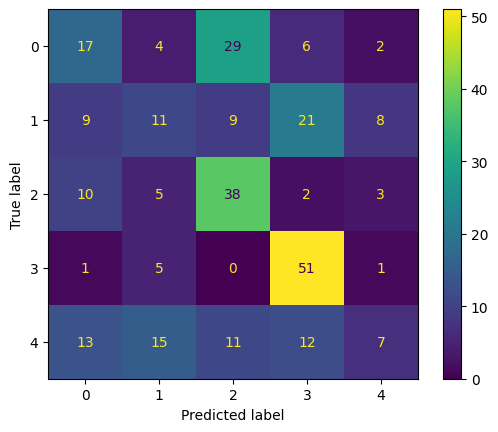

In [20]:
cm = confusion_matrix(val_true_list, val_pred_list)
cm_display = ConfusionMatrixDisplay(cm).plot()

#### Evaluation - Scores

In [21]:
print("Accuracy Score: ", accuracy_score(val_true_list, val_pred_list))
print("Precision Score: ", precision_score(val_true_list, val_pred_list, average='macro'))
print("Recall Score: ", recall_score(val_true_list, val_pred_list, average='macro'))
print("F1 Score: ", f1_score(val_true_list, val_pred_list, average='macro'))

Accuracy Score:  0.42758620689655175
Precision Score:  0.3878925537231384
Recall Score:  0.4275862068965517
F1 Score:  0.38413154632821656


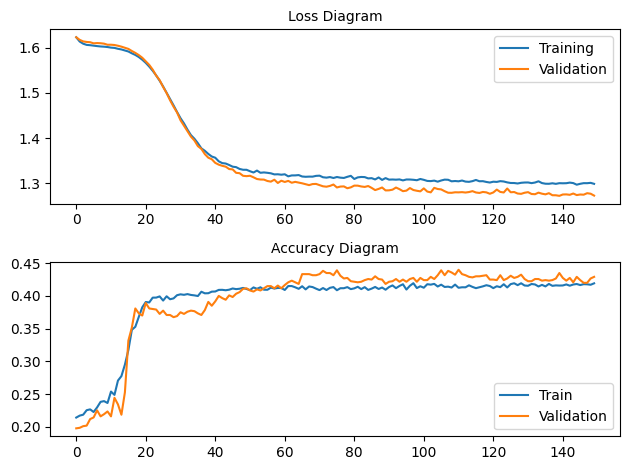

In [22]:
plt.subplot(2, 1, 1)
plt.plot(np.array(summary_train_loss),label="Training")
plt.plot(np.array(summary_val_loss),label="Validation")
plt.title("Loss Diagram", fontsize = 10)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(np.array(summary_train_accuracy),label="Train")
plt.plot(np.array(summary_val_accuracy),label="Validation")
plt.title("Accuracy Diagram", fontsize = 10)
plt.legend()
plt.tight_layout()

#### Save model to local disk

In [25]:
# Save Model Path
path = "Phase II - Species Distribution Model.pth"
torch.save(net.state_dict(),path)
print("Model saved to local disk.")

Model saved to local disk.


In [26]:
evaluation = pd.DataFrame(columns = ["train loss","train accuracy","validation loss","validation accuracy"])
evaluation["train loss"] =summary_train_loss
evaluation["train accuracy"] =summary_train_accuracy
evaluation["validation loss"] =summary_val_loss
evaluation["validation accuracy"] = summary_val_accuracy
evaluation.to_csv("Phase II - model_evaluation.csv",index=False,mode="a",header=None)
print("Evaluation Metrics saved to local disk.")

Evaluation Metrics saved to local disk.
